In [75]:
import numpy as np
from scipy.stats import pearsonr
from ElectionForecasting.src.root import ROOT_DIR
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
from statsmodels.stats.correlation_tools import corr_nearest
from statsmodels.stats.correlation_tools import cov_nearest
from scipy.linalg import cholesky
from scipy.linalg import sqrtm
from ElectionForecasting.src.config import party_order, province_order
from scipy.stats import pearsonr
from ElectionForecasting.src.data.processing.process_partisan_leans import load_election_results
# Load the demographic data
demographics_df = pd.read_csv(f'{ROOT_DIR}/data/dataland/dataland_demographics.csv')
demographics_df = demographics_df.set_index('province').loc[province_order].reset_index()
# Load the election results data
election_results_df = pd.read_csv(f'{ROOT_DIR}/data/dataland/dataland_election_results_1984_2023.csv')


In [101]:

# Create a dictionary that maps each province to its rank in the custom order
custom_rank = {province: rank for rank, province in enumerate(province_order)}

# Assign a custom rank to each row based on the 'province' column
election_results_df['custom_rank'] = election_results_df['province'].map(custom_rank)

# Sort the DataFrame first by 'year' and then by the custom rank
election_results_df = election_results_df.sort_values(by=['year', 'custom_rank'])
election_results_df.drop(columns='custom_rank', inplace=True)
election_results_df

,year,province,region,party_in_power,provincial_winner,national_winner,national_pop_vote_winner,cc_share,dgm_share,pdal_share,ssp_share
3,1984,Cerebrica,Synapse Territories,pdal,pdal,pdal,pdal,0.308617,0.274261,0.320309,0.096813
5,1984,Cortexia,Synapse Territories,pdal,ssp,pdal,pdal,0.145292,0.175291,0.270709,0.408708
9,1984,Neuronia,Synapse Territories,pdal,ssp,pdal,pdal,0.040115,0.105834,0.078219,0.775831
0,1984,Amperville,Circuit Confederation,pdal,pdal,pdal,pdal,0.047924,0.181743,0.770333,0.000000
1,1984,Binaryshire,Metaflux Realm,pdal,cc,pdal,pdal,0.829564,0.022409,0.148026,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
474,2023,Electropolis,Circuit Confederation,pdal,dgm,pdal,pdal,0.285425,0.380320,0.334255,0.000000
475,2023,Infinitron Peninsula,Metaflux Realm,pdal,cc,pdal,pdal,0.423952,0.330976,0.245072,0.000000
476,2023,Infoglen,Metaflux Realm,pdal,cc,pdal,pdal,0.355367,0.318422,0.326211,0.000000
478,2023,Quantumridge,Metaflux Realm,pdal,pdal,pdal,pdal,0.178276,0.340202,0.481521,0.000000


In [102]:
election_results = load_election_results(f'{ROOT_DIR}/data/interim/state_results/')
election_results[0]

('1984',
                       cc_share  dgm_share  pdal_share  ssp_share
 province                                                        
 Amperville            0.047924   0.181743    0.770333   0.000000
 Binaryshire           0.829564   0.022409    0.148026   0.000000
 Byteforge Domain      0.438357   0.082160    0.479483   0.000000
 Cerebrica             0.308617   0.274261    0.320309   0.096813
 Circuiton             0.073943   0.480847    0.445211   0.000000
 Cortexia              0.145292   0.175291    0.270709   0.408708
 Electropolis          0.259892   0.372713    0.367395   0.000000
 Infinitron Peninsula  0.443475   0.296444    0.260081   0.000000
 Infoglen              0.368296   0.283831    0.347873   0.000000
 Neuronia              0.040115   0.105834    0.078219   0.775831
 Quantumridge          0.201873   0.283214    0.514913   0.000000
 Voltagea              0.099608   0.391433    0.508958   0.000000)

In [103]:
share_order = [p+'_share' for p in party_order]
election_results = [(y, er.loc[province_order][share_order]) for y, er in election_results]
election_results[0]

('1984',
                       cc_share  dgm_share  pdal_share  ssp_share
 province                                                        
 Cerebrica             0.308617   0.274261    0.320309   0.096813
 Cortexia              0.145292   0.175291    0.270709   0.408708
 Neuronia              0.040115   0.105834    0.078219   0.775831
 Amperville            0.047924   0.181743    0.770333   0.000000
 Binaryshire           0.829564   0.022409    0.148026   0.000000
 Byteforge Domain      0.438357   0.082160    0.479483   0.000000
 Circuiton             0.073943   0.480847    0.445211   0.000000
 Electropolis          0.259892   0.372713    0.367395   0.000000
 Infinitron Peninsula  0.443475   0.296444    0.260081   0.000000
 Infoglen              0.368296   0.283831    0.347873   0.000000
 Quantumridge          0.201873   0.283214    0.514913   0.000000
 Voltagea              0.099608   0.391433    0.508958   0.000000)

In [104]:
# Try running the code again to calculate the provincial deviations from the national vote in each year
parties = share_order
# Filter out the relevant columns for vote shares
vote_shares_df = election_results_df[['year', 'province']+share_order]

# Calculate the national vote as the mean of the election results in each province for each year, replacing NaNs with 0
national_vote_df  = vote_shares_df.fillna(0).groupby('year').agg({p: 'mean' for p in parties})

# Merge the national vote back into the original DataFrame to facilitate the calculation of deviations
merged_df = pd.merge(vote_shares_df, national_vote_df, on='year', suffixes=('', '_national'))

# Calculate how much each province deviated from the national vote in each year
for col in parties:
    merged_df[f'{col}'] = merged_df[col] - merged_df[f'{col}_national']
    merged_df.drop(columns=f'{col}_national', inplace=True)
# Filter to keep only the deviation columns
vote_Shares_df = merged_df#[['year', 'province', 'cc_share_deviation', 'dgm_share_deviation', 'pdal_share_deviation', 'ssp_share_deviation']]
vote_Shares_df

,year,province,cc_share,dgm_share,pdal_share,ssp_share
0,1984,Cerebrica,0.037204,0.028413,-0.055650,-0.009967
1,1984,Cortexia,-0.126121,-0.070558,-0.105250,0.301929
2,1984,Neuronia,-0.231298,-0.140014,-0.297740,0.669052
3,1984,Amperville,-0.223489,-0.064105,0.394374,-0.106779
4,1984,Binaryshire,0.558151,-0.223439,-0.227933,-0.106779
...,...,...,...,...,...,...
475,2023,Electropolis,0.018113,0.098727,-0.023385,-0.093456
476,2023,Infinitron Peninsula,0.156639,0.049384,-0.112568,-0.093456
477,2023,Infoglen,0.088055,0.036830,-0.031429,-0.093456
478,2023,Quantumridge,-0.089036,0.058610,0.123881,-0.093456


In [105]:
# Function to calculate the correlation and p-value
def calculate_correlation_and_pvalue(df, column1, column2):
    corr, p_value = pearsonr(df[column1], df[column2])
    return corr if p_value < 0.05 else 0

# Convert the multi-index to a single concatenated index
def concatenate_multi_index(multi_index):
    return [f"{state}_{party}" for state, party in multi_index]

def plot_heatmap(df, title='Pairwise Correlations Across All States and Parties'):
    # Plot the large correlation matrix as a heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.fillna(0), annot=False, cmap='coolwarm', cbar=True, square=True)
    plt.title(title)
    # plt.show()

# Define a function to integrate the cross-sectional correlation into the province-specific correlation matrices
def integrate_cross_sectional_correlation(province_corr, cross_sectional_corr):
    # Find common parties between the two matrices
    common_parties = list(set(province_corr.columns).intersection(set(cross_sectional_corr.index)))
    
    # Extract the sub-matrices corresponding to the common parties
    province_sub_matrix = province_corr.loc[common_parties, common_parties]
    
    # Integrate the two matrices. Here, we'll replace the diagonal with the values from cross_sectional_corr
    for party in common_parties:
        for demographic in cross_sectional_corr.columns:
            if province_corr.columns.isin([demographic]).any():
                province_corr.loc[party, demographic] = cross_sectional_corr.loc[party, demographic]
                province_corr.loc[demographic, party] = cross_sectional_corr.loc[party, demographic]
                
    return province_corr

# Function to calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Function to make sure the matrix is real after making it PSD
def ensure_real(matrix):
    return np.real(matrix)


In [106]:

# # Filter out the relevant columns for vote shares
vote_shares_df = election_results_df[['year', 'province']+share_order]
# # List of parties to consider for correlation
parties = [p+'_share' for p in party_order]
relevant_demographics = ['population', 'python_pop_share', 'cobolite_pop_share', 'javarian_pop_share']
average_vote_shares_df = vote_shares_df.groupby('province')[parties].mean().reset_index()
demographics_filtered_df = demographics_df[['province'] + relevant_demographics]
merged_df = pd.merge(average_vote_shares_df, demographics_filtered_df, on='province', how='inner')
example_provinces = ['Amperville', 'Cerebrica']
# Initialize a DataFrame to store significant cross-sectional correlations
significant_cross_sectional_correlation = pd.DataFrame(index=parties, columns=relevant_demographics)

# Calculate significant cross-sectional correlations
for party in parties:
    for feature in relevant_demographics:
        significant_cross_sectional_correlation.at[party, feature] = calculate_correlation_and_pvalue(merged_df, party, feature)

significant_cross_sectional_correlation
# Define a function to integrate the cross-sectional correlation into the province-specific correlation matrices
def integrate_cross_sectional_correlation(province_corr, cross_sectional_corr):
    # Find common parties between the two matrices
    common_parties = list(set(province_corr.columns).intersection(set(cross_sectional_corr.index)))
    
    # Extract the sub-matrices corresponding to the common parties
    province_sub_matrix = province_corr.loc[common_parties, common_parties]
    
    # Integrate the two matrices. Here, we'll replace the diagonal with the values from cross_sectional_corr
    for party in common_parties:
        for demographic in cross_sectional_corr.columns:
            if province_corr.columns.isin([demographic]).any():
                province_corr.loc[party, demographic] = cross_sectional_corr.loc[party, demographic]
                province_corr.loc[demographic, party] = cross_sectional_corr.loc[party, demographic]
                
    return province_corr
significant_cross_sectional_correlation

,population,python_pop_share,cobolite_pop_share,javarian_pop_share
cc_share,0,-0.797088,0.932345,0
dgm_share,0,0,0,0.619615
pdal_share,0,0,0,0
ssp_share,0,0,0,0


In [107]:
demographics_filtered_df

,province,population,python_pop_share,cobolite_pop_share,javarian_pop_share
0,Cerebrica,850000,0.404046,0.529105,0.066849
1,Cortexia,1400000,0.592846,0.170363,0.236791
2,Neuronia,250000,0.676468,0.100817,0.222715
3,Amperville,1000000,0.765173,0.084048,0.150780
4,Binaryshire,150000,0.030380,0.927361,0.042259
5,Byteforge Domain,650000,0.545108,0.317107,0.137786
6,Circuiton,500000,0.402774,0.059544,0.537682
7,Electropolis,2250000,0.265686,0.229266,0.505048
8,Infinitron Peninsula,200000,0.167412,0.439659,0.392929
9,Infoglen,1750000,0.134158,0.295264,0.570578


In [150]:
# Define the custom order for provinces and parties
provinces = province_order  # Custom order for provinces as defined earlier
parties = share_order  # Given order for parties

# Generate the ordered list of column names in the order of a flattened array
flattened_order = [f"{province}_{party}" for province in provinces for party in parties]


# Show some of the generated data
flattened_order

['Cerebrica_cc_share',
 'Cerebrica_dgm_share',
 'Cerebrica_pdal_share',
 'Cerebrica_ssp_share',
 'Cortexia_cc_share',
 'Cortexia_dgm_share',
 'Cortexia_pdal_share',
 'Cortexia_ssp_share',
 'Neuronia_cc_share',
 'Neuronia_dgm_share',
 'Neuronia_pdal_share',
 'Neuronia_ssp_share',
 'Amperville_cc_share',
 'Amperville_dgm_share',
 'Amperville_pdal_share',
 'Amperville_ssp_share',
 'Binaryshire_cc_share',
 'Binaryshire_dgm_share',
 'Binaryshire_pdal_share',
 'Binaryshire_ssp_share',
 'Byteforge Domain_cc_share',
 'Byteforge Domain_dgm_share',
 'Byteforge Domain_pdal_share',
 'Byteforge Domain_ssp_share',
 'Circuiton_cc_share',
 'Circuiton_dgm_share',
 'Circuiton_pdal_share',
 'Circuiton_ssp_share',
 'Electropolis_cc_share',
 'Electropolis_dgm_share',
 'Electropolis_pdal_share',
 'Electropolis_ssp_share',
 'Infinitron Peninsula_cc_share',
 'Infinitron Peninsula_dgm_share',
 'Infinitron Peninsula_pdal_share',
 'Infinitron Peninsula_ssp_share',
 'Infoglen_cc_share',
 'Infoglen_dgm_share',
 'I

In [108]:
# Reshape the deviation_df to make it suitable for calculating the correlation matrix
reshaped_deviation_df = vote_shares_df.melt(id_vars=['year', 'province'], var_name='party', value_name='deviation')

# Create a composite column that combines province and party
reshaped_deviation_df['province_party'] = reshaped_deviation_df['province'] + "_" + reshaped_deviation_df['party']

# Pivot the table to get a DataFrame suitable for calculating correlations
# NB: The pivot operation breaks the previous column and index ordering
pivot_deviation_df = reshaped_deviation_df.pivot(index='year', columns='province_party', values='deviation')

In [156]:
pivot_deviation_df = pivot_deviation_df[flattened_order]

In [157]:
# integrate_cross_sectional_correlation(significant_province_correlation_matrices['Amperville'], 
#                                                                      significant_cross_sectional_correlation)

Constant values! Setting corr to 0. Cerebrica_cc_share - Amperville_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Binaryshire_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Byteforge Domain_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Circuiton_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Electropolis_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Infinitron Peninsula_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Infoglen_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Quantumridge_ssp_share
Constant values! Setting corr to 0. Cerebrica_cc_share - Voltagea_ssp_share
Constant values! Setting corr to 0. Cerebrica_dgm_share - Amperville_ssp_share
Constant values! Setting corr to 0. Cerebrica_dgm_share - Binaryshire_ssp_share
Constant values! Setting corr to 0. Cerebrica_dgm_share - Byteforge Domain_ssp_share
Constant values! Setting corr to 0. Ce

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/statsmodels/stats/moment_helpers.py:252: RuntimeWarning:

invalid value encountered in divide

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning:


Maximum iteration reached.




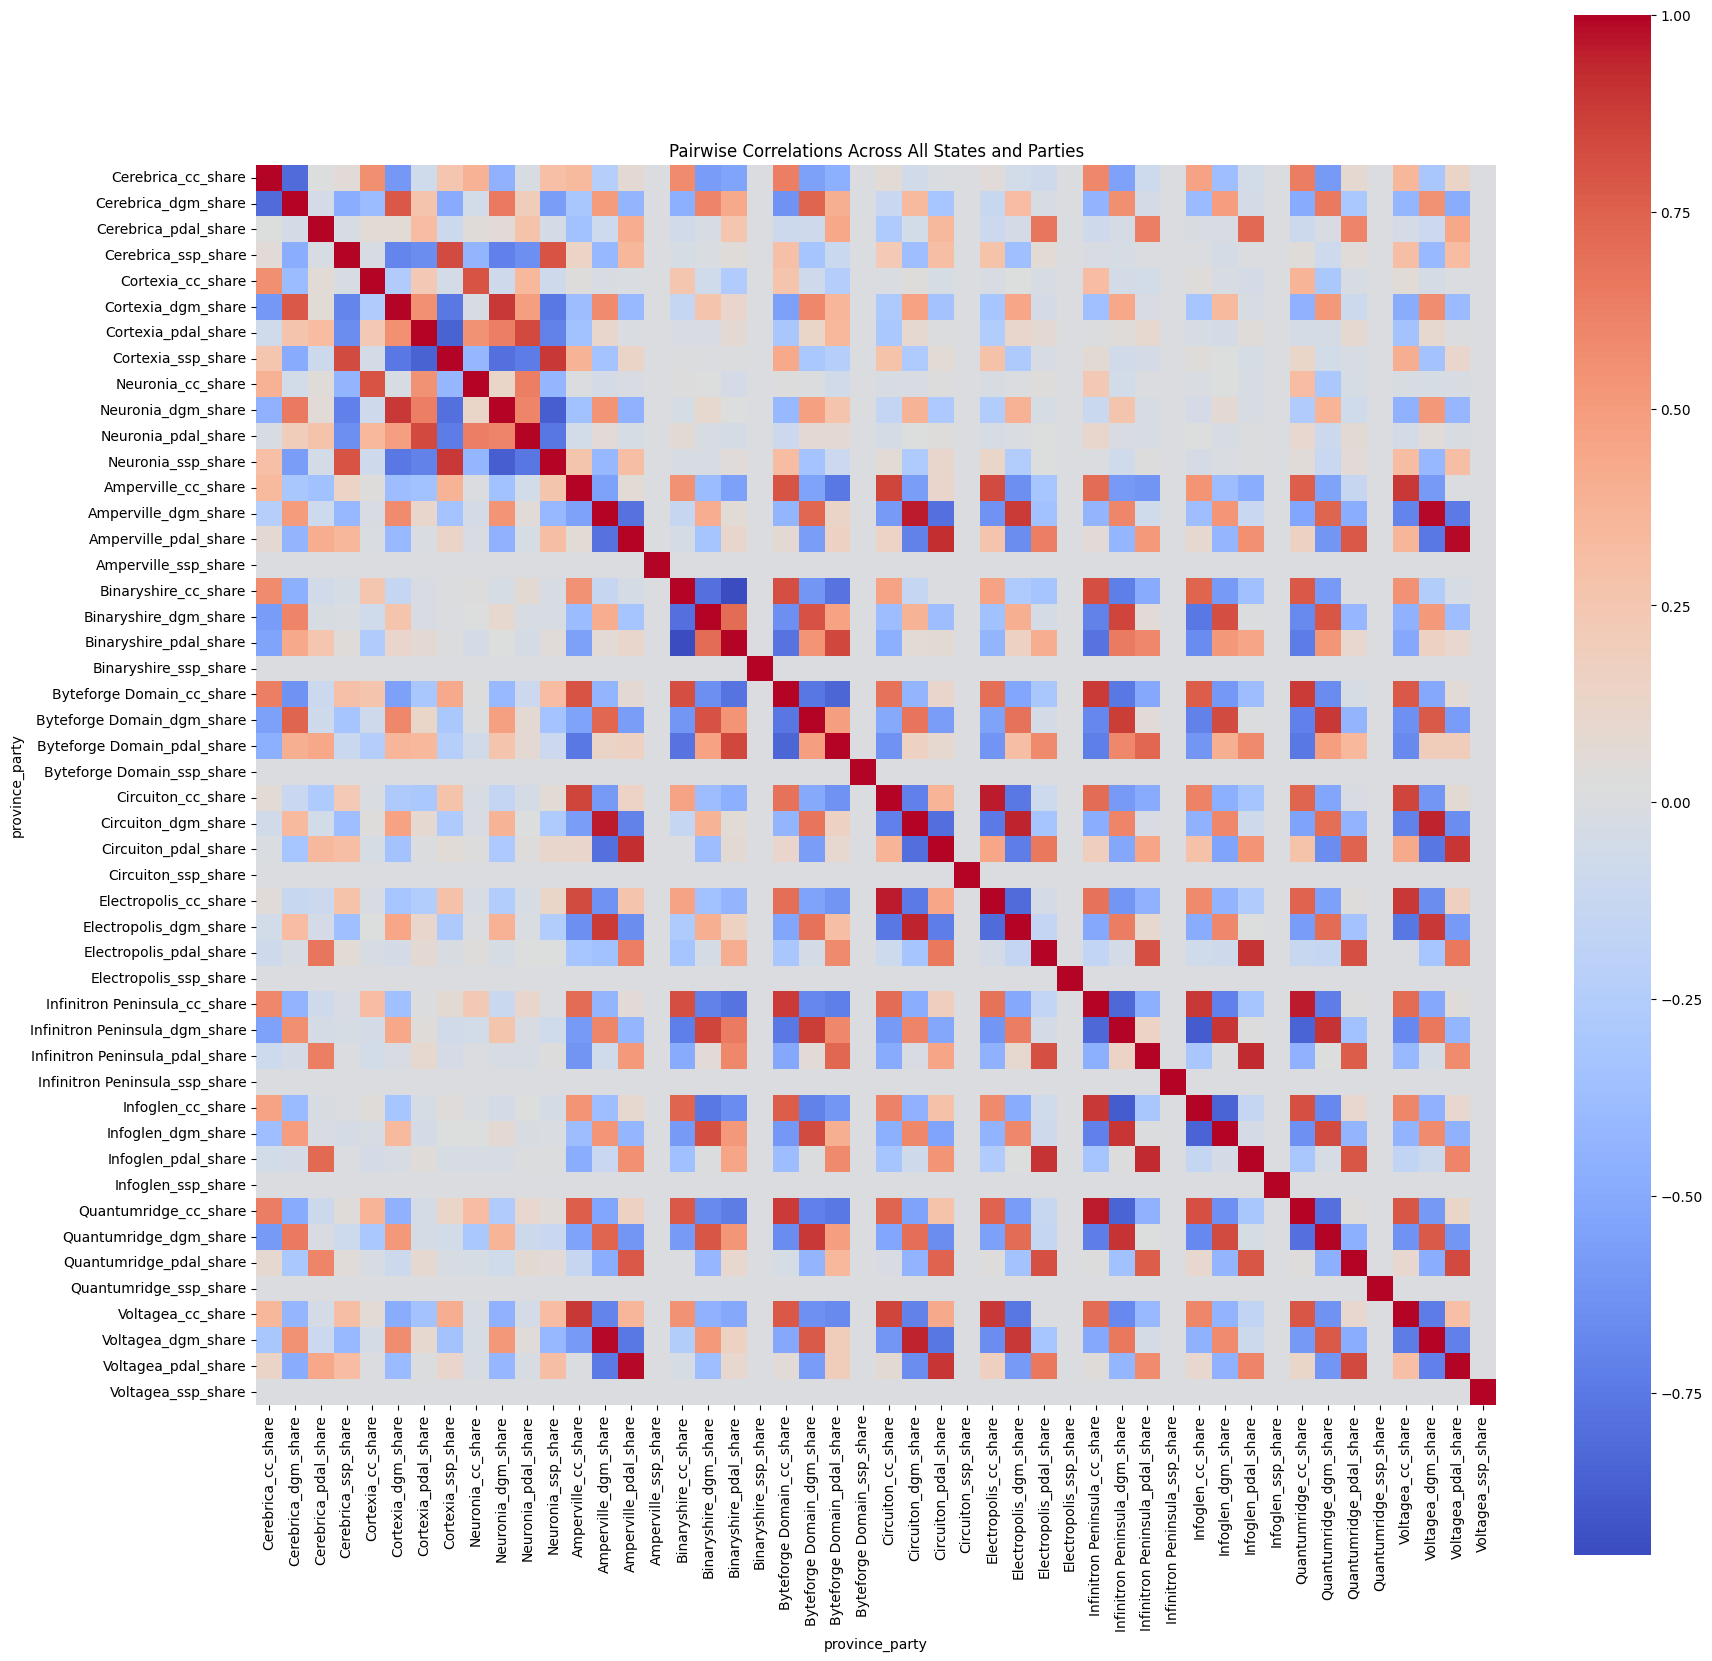

In [158]:
def fix_cov(cov):
    # Compute the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)
    # Take the real parts of the eigenvalues and eigenvectors
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)

    # Replace negative eigenvalues with small positive values (e.g., 1e-8)
    eigvals[eigvals < 0] = 1e-8

    # Reconstruct the matrix
    reconstructed_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Ensure the diagonal is exactly 1.0 for a correlation matrix
    np.fill_diagonal(reconstructed_matrix, 1.0)
    # Make sure the matrix is real
    reconstructed_matrix = np.real(reconstructed_matrix)
    return reconstructed_matrix

# Eigenvalue correction method
def eigenvalue_correction(corr_matrix):
    eigvals, eigvecs = np.linalg.eig(corr_matrix)
    eigvals[eigvals < 0] = 0
    corrected_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return ensure_real(corrected_matrix)

# Higham's method
def higham_method(corr_matrix, max_iter=100, tol=1e-6):
    Y = corr_matrix.copy()
    for _ in range(max_iter):
        eigvals, eigvecs = np.linalg.eig(Y)
        Q = eigvecs @ np.diag(np.maximum(eigvals, 0)) @ eigvecs.T
        Y = (Y + Q) / 2
        if np.linalg.norm(Y - Q, 'fro') < tol:
            break
    return ensure_real(Y)


def nearest_covariance(df):
    nearest_cov_matrix = cov_nearest(df)
    # Normalize to get the correlation matrix
    variances = np.diag(nearest_cov_matrix)
    diag_matrix_inv_sqrt = np.diag(1 / np.sqrt(variances))
    nearest_corr_matrix = diag_matrix_inv_sqrt @ nearest_cov_matrix @ diag_matrix_inv_sqrt
    np.fill_diagonal(nearest_corr_matrix, 1.0)
    nearest_is_positive_semi_definite = np.all(np.linalg.eigvals(nearest_corr_matrix) >= -1e-8)
    assert nearest_is_positive_semi_definite
    distance = frobenius_norm(df, nearest_corr_matrix)
    return nearest_corr_matrix

# Define a function to compute correlation and p-value, and filter based on significance level
def filter_significant_corr(df, alpha=0.05):
    df.fillna(0, inplace=True)
    cov_matrix = df.cov()
    corr_matrix = df.corr()
    p_values_matrix = corr_matrix.copy()
    
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 == col2:
                p_values_matrix.loc[col1, col2] = 0  # Same variable; p-value is irrelevant
            else:
                non_na_indices = df[[col1, col2]].dropna().index
                x = df.loc[non_na_indices, col1]
                y = df.loc[non_na_indices, col2]
                if np.all(x == y):
                    print(f'Constant values! Setting corr to 0. {col1} - {col2}')
                    p_values_matrix.loc[col1, col2] = 0
                    continue
                if (np.all(x)==x.iloc[0]) or (np.all(y)==y.iloc[0]):
                    print(f'Constant values! Setting corr to 0. {col1} - {col2}')
                    p_values_matrix.loc[col1, col2] = 0
                    continue
                if len(x) > 1:  # Need at least two non-NA observations to perform the test
                    _, p_value = pearsonr(x, y)
                    p_values_matrix.loc[col1, col2] = p_value
                else:
                    p_values_matrix.loc[col1, col2] = 1  # Set to non-significant if not enough data
    
    # Filter based on significance level
    significant_corr_matrix = corr_matrix.where(p_values_matrix < alpha, np.nan)
    significant_cov_matrix = cov_matrix.where(p_values_matrix < alpha, np.nan)
    significant_corr_matrix.fillna(0, inplace=True)
    significant_cov_matrix.fillna(0, inplace=True)
    significant_cov_matrix_SPD = cov_nearest(significant_cov_matrix.values, method='clipped', threshold=1e-15, n_fact=100, return_all=False)
    significant_corr_matrix_SPD = corr_nearest(significant_corr_matrix.values, threshold=1e-10, n_fact=10000)
    # significant_corr_matrix_SPD = nearest_covariance(significant_corr_matrix) #
    # print(np.any((significant_cov_matrix_SPD - significant_cov_matrix.values).round() > 0))
    significant_cov_matrix = pd.DataFrame(significant_cov_matrix_SPD, columns=significant_cov_matrix.columns, index=significant_cov_matrix.index)
    significant_corr_matrix = pd.DataFrame(significant_corr_matrix_SPD, columns=significant_corr_matrix.columns, index=significant_corr_matrix.index)
    return significant_corr_matrix, significant_cov_matrix, p_values_matrix

# Calculate and filter the correlation matrix in one step
significant_corr_matrix, significant_cov_matrix, p_values_matrix = filter_significant_corr(pivot_deviation_df)
plot_heatmap(significant_corr_matrix)
plt.savefig(f'{ROOT_DIR}/plots/static_plots/correlation_matrix.png')
plt.show()

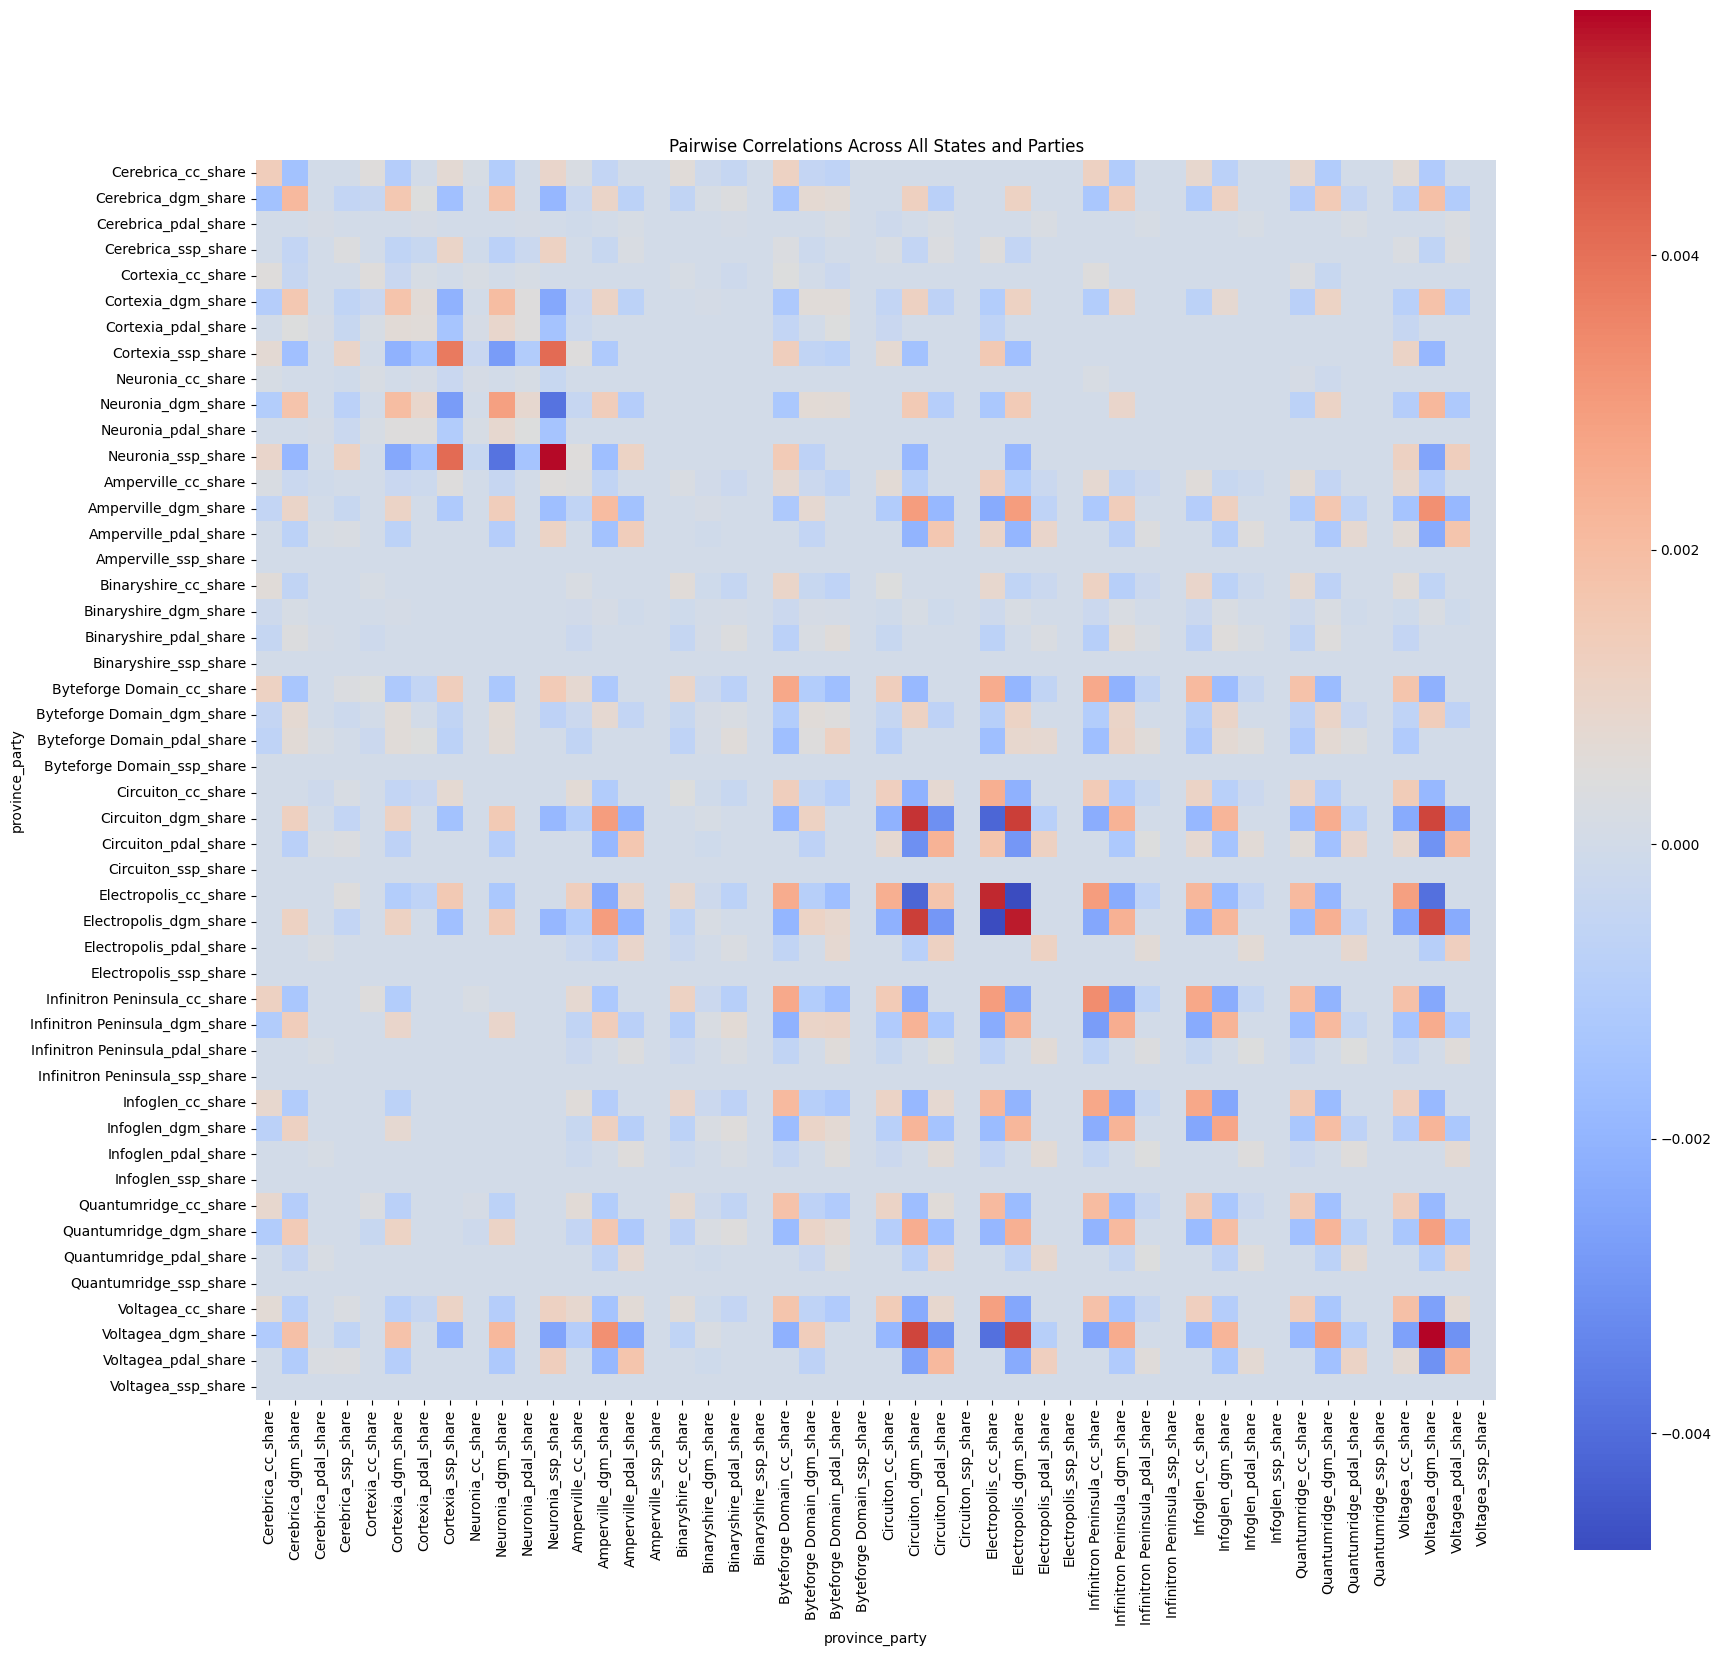

In [172]:
plot_heatmap(significant_cov_matrix)

In [173]:
significant_corr_matrix.to_csv((f'{ROOT_DIR}/data/processed/state_vote_correlations.csv'))
significant_cov_matrix.to_csv((f'{ROOT_DIR}/data/processed/state_vote_covariance.csv'))

In [160]:
significant_cov_matrix.min().min()

-0.0047929112310336535

In [161]:

# Check if the matrix is square
is_square_new = significant_corr_matrix.shape[0] == significant_corr_matrix.shape[1]

# Check if the matrix is symmetric
is_symmetric_new = np.allclose(significant_corr_matrix, significant_corr_matrix.T, atol=1e-8)

# Check if the matrix is positive semi-definite
eigenvalues_new = np.linalg.eigvals(significant_corr_matrix)
is_positive_semi_definite_new = np.all(eigenvalues_new >= -1e-8)  # small numerical tolerance

# Check for NaN or infinite values in the matrix
has_nan = np.any(np.isnan(significant_corr_matrix).any())
has_inf = np.any(np.isinf(significant_corr_matrix).any())

is_square_new, is_symmetric_new, is_positive_semi_definite_new, eigenvalues_new.min(), has_nan, has_inf

(True, True, True, (9.999733096152334e-11+0j), False, False)

In [162]:
from scipy.linalg import cholesky
from statsmodels.stats.correlation_tools import cov_nearest
new_corr_matrix_values = significant_corr_matrix.copy()
# Function to calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Initialize dictionary to store results
results = {}

# 1. Eigenvalue Correction
eigvals, eigvecs = np.linalg.eig(new_corr_matrix_values)
eigvals[eigvals < 0] = 1e-8
eigen_corrected_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
np.fill_diagonal(eigen_corrected_matrix, 1.0)
eigen_is_positive_semi_definite = np.all(np.linalg.eigvals(eigen_corrected_matrix) >= -1e-8)
results['Eigenvalue Correction'] = {
    'is_positive_semi_definite': eigen_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, eigen_corrected_matrix)
}

# 2. Higham's Method
higham_matrix = new_corr_matrix_values.copy()
for _ in range(100):  # Max 100 iterations
    eigvals, eigvecs = np.linalg.eig(higham_matrix)
    eigvals[eigvals < 0] = 0
    higham_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    higham_matrix = 0.5 * (higham_matrix + higham_matrix.T)
    np.fill_diagonal(higham_matrix, 1.0)
higham_is_positive_semi_definite = np.all(np.linalg.eigvals(higham_matrix) >= -1e-8)
results['Higham'] = {
    'is_positive_semi_definite': higham_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, higham_matrix)
}

# # 3. Adding a multiple of the identity matrix
# identity_added_matrix = new_corr_matrix_values.copy()
# smallest_eigval = np.min(np.linalg.eigvals(identity_added_matrix))
# i = 1e-8
# while smallest_eigval < 0:
#     identity_added_matrix = new_corr_matrix_values + i * np.identity(new_corr_matrix_values.shape[0])
#     smallest_eigval = np.min(np.linalg.eigvals(identity_added_matrix))
#     i += 1e-8
# identity_is_positive_semi_definite = np.all(np.linalg.eigvals(identity_added_matrix) >= -1e-8)
# results['Identity Addition'] = {
#     'is_positive_semi_definite': identity_is_positive_semi_definite,
#     'change': frobenius_norm(new_corr_matrix_values, identity_added_matrix)
# }

# 4. Nearest Covariance Matrix (cov_nearest)
nearest_cov_matrix = cov_nearest(new_corr_matrix_values)
# Normalize to get the correlation matrix
variances = np.diag(nearest_cov_matrix)
diag_matrix_inv_sqrt = np.diag(1 / np.sqrt(variances))
nearest_corr_matrix = diag_matrix_inv_sqrt @ nearest_cov_matrix @ diag_matrix_inv_sqrt
np.fill_diagonal(nearest_corr_matrix, 1.0)
nearest_is_positive_semi_definite = np.all(np.linalg.eigvals(nearest_corr_matrix) >= -1e-8)
results['Nearest Covariance'] = {
    'is_positive_semi_definite': nearest_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, nearest_corr_matrix)
}


In [163]:
results

{'Eigenvalue Correction': {'is_positive_semi_definite': False,
  'change': 1.9376560430740224},
 'Higham': {'is_positive_semi_definite': False, 'change': 1.8359403941063144},
 'Nearest Covariance': {'is_positive_semi_definite': True, 'change': 0.0}}

In [164]:
# Function to calculate the correlation matrix with p-value filtering
def calculate_filtered_corr_matrix(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1  # Same variable; correlation is 1
            else:
                non_na_indices = df[[col1, col2]].dropna().index
                x = df.loc[non_na_indices, col1]
                y = df.loc[non_na_indices, col2]
                if len(x) > 1:  # Need at least two non-NA observations to perform the test
                    corr, p_value = pearsonr(x, y)
                    corr_matrix.loc[col1, col2] = corr if p_value < 0.05 else 0
                else:
                    corr_matrix.loc[col1, col2] = 0  # Set to 0 if not enough data
    return corr_matrix.astype(float)

# Calculate the filtered correlation matrix
filtered_corr_matrix = calculate_filtered_corr_matrix(pivot_deviation_df)

results_real = {}
# Apply methods and calculate Frobenius norm for the change in each case
methods = {'Eigenvalue Correction': eigenvalue_correction,
           'Higham\'s Method': higham_method,
           'Nearest Covariance': nearest_covariance}

for method, func in methods.items():
    try:
        transformed_matrix = func(filtered_corr_matrix.values)
        is_positive_semi_definite = np.all(np.linalg.eigvals(transformed_matrix) >= -1e-8)
        frobenius_change = frobenius_norm(filtered_corr_matrix.values, transformed_matrix)
        results_real[method] = {
            'is_positive_semi_definite': is_positive_semi_definite,
            'frobenius_change': frobenius_change
        }
    except Exception as e:
        results_real[method] = {'error': str(e)}

results_real

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is 

{'Eigenvalue Correction': {'is_positive_semi_definite': True,
  'frobenius_change': 1.9470911563786018},
 "Higham's Method": {'is_positive_semi_definite': False,
  'frobenius_change': 1.9470902279331876},
 'Nearest Covariance': {'is_positive_semi_definite': True,
  'frobenius_change': 3.2371363950221514}}

In [165]:
# cov_filled = pd.DataFrame(eigenvalue_correction(filtered_corr_matrix.values), columns=filtered_corr_matrix.columns, index=filtered_corr_matrix.index)
# plot_heatmap(cov_filled)
# significant_corr_matrix = cov_filled.copy()


In [166]:
significant_corr_matrix

province_party,Cerebrica_cc_share,Cerebrica_dgm_share,Cerebrica_pdal_share,Cerebrica_ssp_share,Cortexia_cc_share,Cortexia_dgm_share,Cortexia_pdal_share,Cortexia_ssp_share,Neuronia_cc_share,Neuronia_dgm_share,...,Infoglen_pdal_share,Infoglen_ssp_share,Quantumridge_cc_share,Quantumridge_dgm_share,Quantumridge_pdal_share,Quantumridge_ssp_share,Voltagea_cc_share,Voltagea_dgm_share,Voltagea_pdal_share,Voltagea_ssp_share
province_party,,,,,,,,,,,,,,,,,,,,,
Cerebrica_cc_share,1.000000e+00,-8.143277e-01,1.826570e-02,5.772396e-02,5.602057e-01,-6.010659e-01,-7.602887e-02,2.527530e-01,3.841825e-01,-4.501306e-01,...,-5.520861e-02,1.569359e-18,6.338336e-01,-5.821180e-01,8.364109e-02,1.417086e-20,3.515343e-01,-3.089179e-01,1.323743e-01,0.0
Cerebrica_dgm_share,-8.143277e-01,1.000000e+00,-4.377442e-02,-4.777801e-01,-3.871424e-01,7.816553e-01,2.741033e-01,-4.897951e-01,-5.861089e-02,6.522145e-01,...,-4.521007e-02,3.181356e-16,-4.904235e-01,6.522104e-01,-2.930785e-01,2.698883e-18,-4.218031e-01,5.468965e-01,-4.852945e-01,0.0
Cerebrica_pdal_share,1.826570e-02,-4.377442e-02,1.000000e+00,-2.016070e-02,6.617968e-02,6.269467e-02,3.261904e-01,-9.362959e-02,4.251354e-02,5.921853e-02,...,7.220641e-01,-8.196724e-18,-9.258377e-02,-1.161248e-02,6.095604e-01,4.705553e-19,-4.415537e-02,-1.056006e-01,4.363403e-01,0.0
Cerebrica_ssp_share,5.772396e-02,-4.777801e-01,-2.016070e-02,1.000000e+00,-2.129008e-02,-6.939386e-01,-6.552079e-01,8.310240e-01,-4.298073e-01,-7.162090e-01,...,6.809793e-03,-1.099486e-16,4.246736e-02,-8.787534e-02,4.905902e-02,6.989183e-19,3.114841e-01,-3.983985e-01,3.205428e-01,0.0
Cortexia_cc_share,5.602057e-01,-3.871424e-01,6.617968e-02,-2.129008e-02,1.000000e+00,-2.675919e-01,2.347332e-01,-5.161429e-02,7.940146e-01,-8.269051e-02,...,-4.519330e-02,1.948876e-16,3.711294e-01,-2.945012e-01,-1.631838e-02,-1.509703e-18,6.709501e-02,-3.193120e-02,1.164905e-03,0.0
Cortexia_dgm_share,-6.010659e-01,7.816553e-01,6.269467e-02,-6.939386e-01,-2.675919e-01,1.000000e+00,5.559525e-01,-7.535408e-01,-2.319190e-02,8.883912e-01,...,-2.160567e-02,2.000354e-16,-4.467813e-01,5.161332e-01,-9.262802e-02,6.116007e-18,-4.887984e-01,5.717270e-01,-3.905646e-01,0.0
Cortexia_pdal_share,-7.602887e-02,2.741033e-01,3.261904e-01,-6.552079e-01,2.347332e-01,5.559525e-01,1.000000e+00,-8.531951e-01,5.463741e-01,6.263292e-01,...,4.023200e-02,4.221030e-16,-3.300669e-02,-3.328152e-02,9.084918e-02,9.381932e-19,-3.372636e-01,9.824276e-02,1.005053e-02,0.0
Cortexia_ssp_share,2.527530e-01,-4.897951e-01,-9.362959e-02,8.310240e-01,-5.161429e-02,-7.535408e-01,-8.531951e-01,1.000000e+00,-4.177464e-01,-7.900004e-01,...,-3.016347e-02,-3.975606e-16,1.270072e-01,-6.097123e-02,-2.094763e-02,-2.377081e-18,4.072085e-01,-3.380634e-01,1.186964e-01,0.0
Neuronia_cc_share,3.841825e-01,-5.861089e-02,4.251354e-02,-4.298073e-01,7.940146e-01,-2.319190e-02,5.463741e-01,-4.177464e-01,1.000000e+00,1.256634e-01,...,-1.664991e-02,-1.378162e-16,3.207711e-01,-2.967923e-01,-2.810796e-02,3.103678e-18,-1.854161e-02,-3.040373e-02,-2.099867e-02,0.0


In [167]:

# # Save significant province correlation matrices
# with open(f'{ROOT_DIR}/data/interim/correlations/significant_province_correlation_matrices.pkl', 'wb') as f:
#     pickle.dump(significant_province_correlation_matrices, f)

# # Save significant cross-sectional correlations
# with open(f'{ROOT_DIR}/data/interim/correlations/significant_cross_sectional_correlation.pkl', 'wb') as f:
#     pickle.dump(significant_cross_sectional_correlation, f)

In [168]:

# Modify the function to make the figure square and adjust the orientation of the diagonal
def plot_significant_correlations_square(corr_matrix, p_values_matrix):
    """
    Plots a heatmap of the correlation matrix without annotations, overlaying p-values where appropriate
    on hover. Only shows significant correlations (based on the p_values_matrix). The figure is square
    and the diagonal runs from top-left to bottom-right.
    
    Parameters:
    - corr_matrix: DataFrame containing correlations
    - p_values_matrix: DataFrame containing p-values
    
    Returns: Plotly Figure
    """
    
    # Convert DataFrames to numpy for easier element-wise operations
    corr_values = corr_matrix.to_numpy()
    p_values = p_values_matrix.to_numpy()
    
    # Create hovertext matrix: show correlation and p-value for each cell
    hovertext = []
    for i in range(corr_values.shape[0]):
        hovertext_row = []
        for j in range(corr_values.shape[1]):
            text = f"{corr_matrix.columns[i].replace('_', ' ').replace(' share', '')} - {corr_matrix.index[j].replace('_', ' ').replace(' share', '')}<br>Correlation: {corr_values[i, j]:.4f}<br>P-Value: {p_values[i, j]:.4f}"
            hovertext_row.append(text)
        hovertext.append(hovertext_row)

    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
                    z=np.flipud(corr_values),  # Flip the matrix upside down for correct orientation
                    x=corr_matrix.columns.str.replace('_', ' ').str.replace(' share', ''),
                    y=corr_matrix.index[::-1].str.replace('_', ' ').str.replace(' share', ''),  # Invert for correct orientation
                    hoverinfo='text',
                    text=np.flipud(hovertext),  # Flip the hovertext as well
                    reversescale=True,
                    colorscale='RdBu')) # Agsunset
    
    # Add titles and labels
    fig.update_layout(
        title='Pairwise Correlation Matrix with P-Values',
        xaxis=dict(title='Party & State', tickfont=dict(size=7)),
        yaxis=dict(title='Party & State', tickfont=dict(size=7)),
        autosize=False,
        width=800,
        height=800  # Square figure
    )
    
    return fig

# Create the plot with hover text only, formatted axis labels, and square figure
fig_square = plot_significant_correlations_square(significant_corr_matrix, p_values_matrix)
fig_square.show()
fig_square.write_html(f'{ROOT_DIR}/plots/static_plots/correlation_matrix.html')

In [169]:
significant_corr_matrix.to_csv(f'{ROOT_DIR}/data/interim/correlations/significant_province_correlation_matrices.csv')
significant_cov_matrix.to_csv(f'{ROOT_DIR}/data/interim/correlations/significant_province_covariance_matrices.csv')

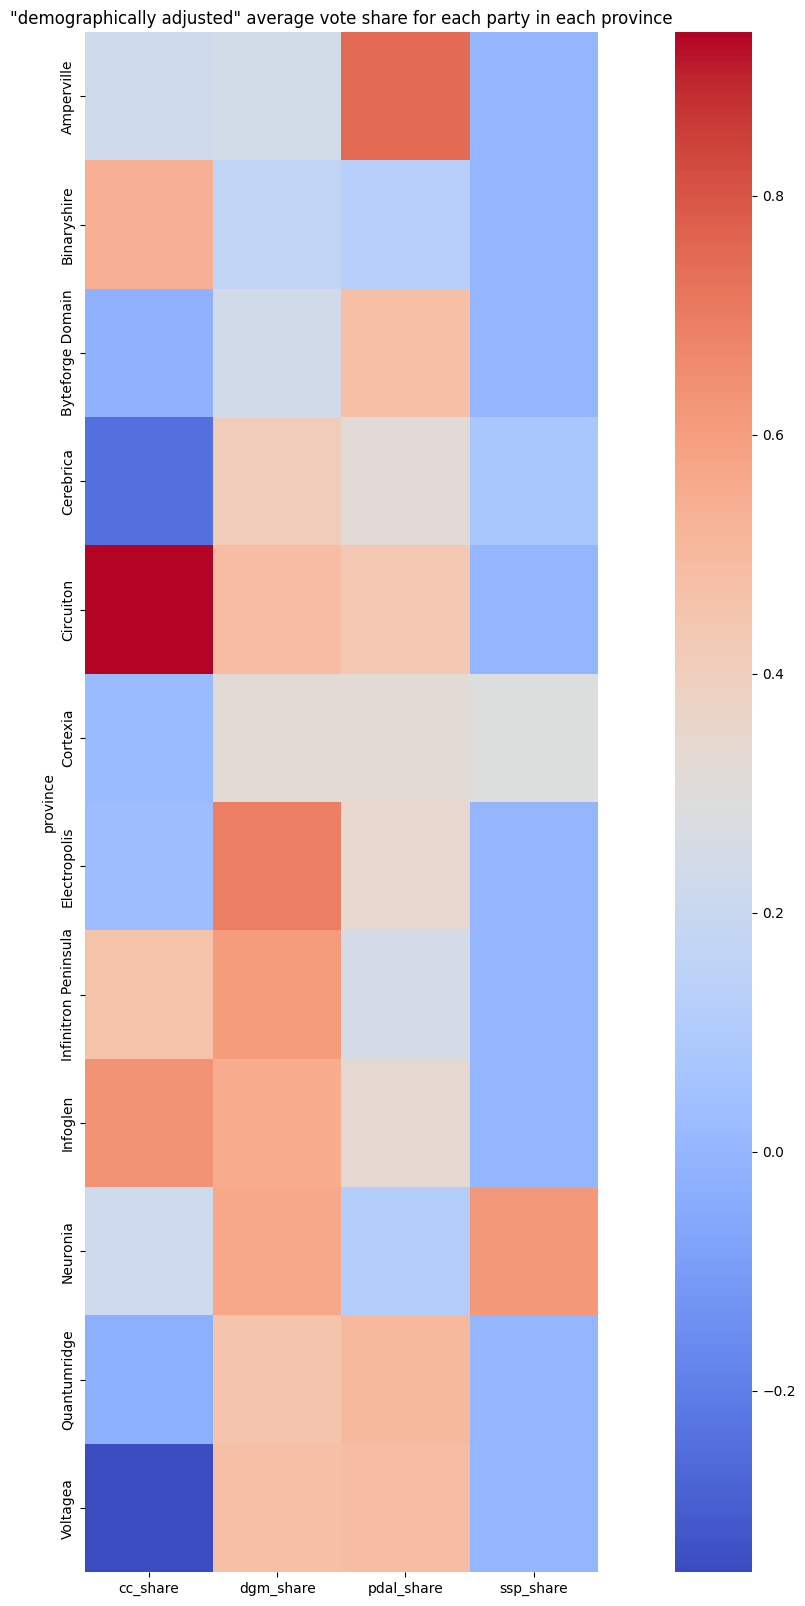

In [170]:
# For each province, multiply the significant cross-sectional correlations by the corresponding demographic values
weighted_demographics_df = demographics_filtered_df.copy()
for party in parties:
    for feature in relevant_demographics:
        correlation = significant_cross_sectional_correlation.at[party, feature]
        if not np.isnan(correlation):
            weighted_feature_name = f"{party}_weighted_by_{feature}"
            weighted_demographics_df[weighted_feature_name] = demographics_filtered_df[feature] * correlation

# Sum the weighted values to get a "demographically adjusted" average vote share for each party in each province
adjusted_vote_shares_df = average_vote_shares_df.copy()
for party in parties:
    weighted_features_for_party = [col for col in weighted_demographics_df.columns if col.startswith(f"{party}_weighted_by_")]
    adjusted_vote_shares_df[party] = average_vote_shares_df[party] + weighted_demographics_df[weighted_features_for_party].sum(axis=1)
adjusted_vote_shares_df.replace(0, np.nan, inplace=True)
plot_heatmap(adjusted_vote_shares_df.set_index('province'), title='"demographically adjusted" average vote share for each party in each province')

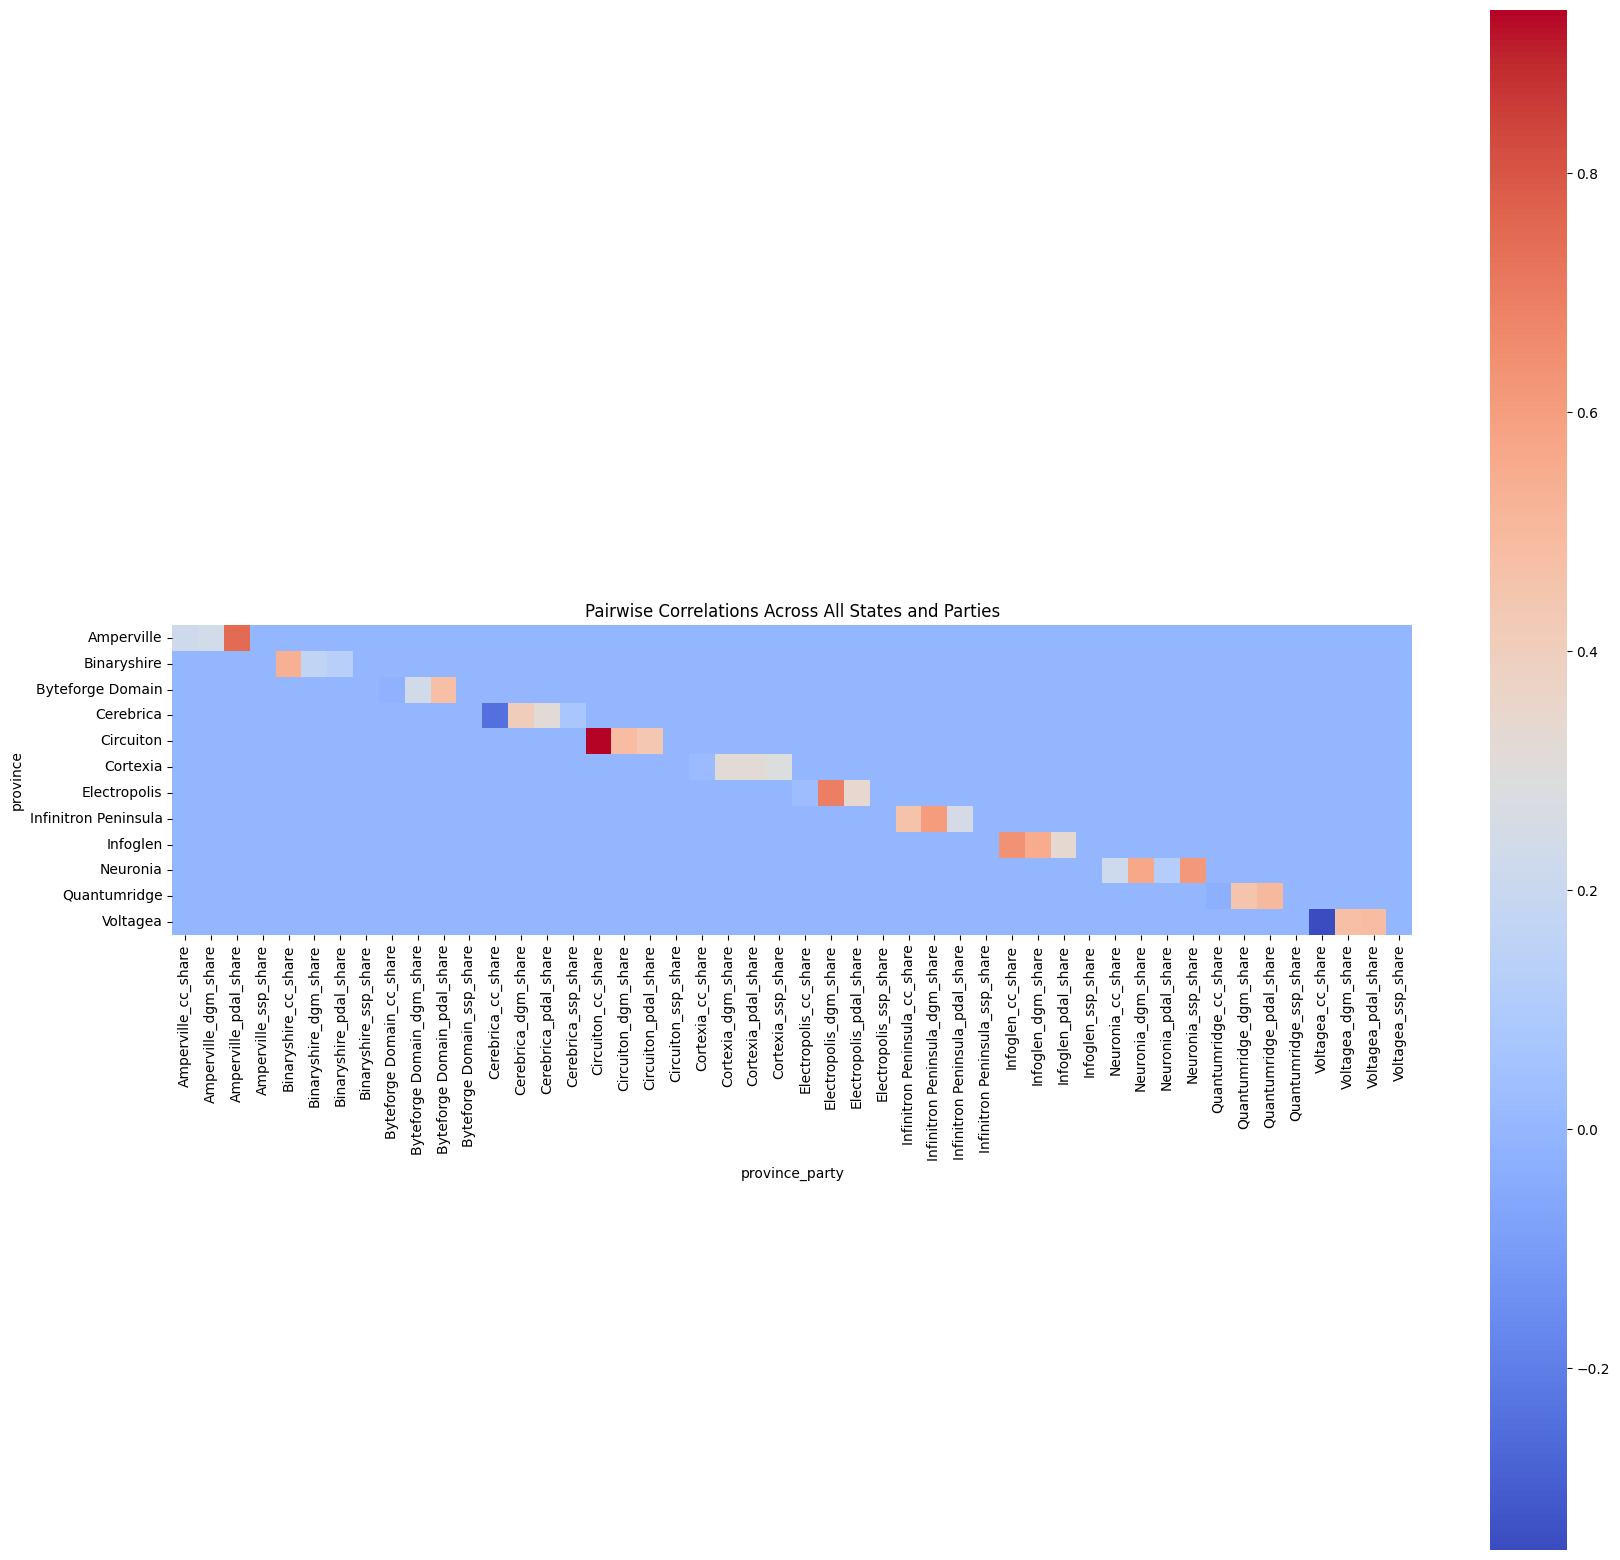

In [171]:
# Reshape the deviation_df to make it suitable for calculating the correlation matrix
reshaped_adjusted_vote_shares_df = adjusted_vote_shares_df.melt(id_vars=['province'], var_name='party', value_name='adjusted')
# # Create a composite column that combines province and party
reshaped_adjusted_vote_shares_df['province_party'] = reshaped_adjusted_vote_shares_df['province'] + "_" + reshaped_adjusted_vote_shares_df['party']

# # Pivot the table to get a DataFrame suitable for calculating correlations
pivot_adjusted_vote_shares_df = reshaped_adjusted_vote_shares_df.pivot(index='province', columns='province_party', values='adjusted')
pivot_adjusted_vote_shares_df.replace(0, np.nan, inplace=True)
plot_heatmap(pivot_adjusted_vote_shares_df)